In [129]:
import numpy as np
from numpy import dot
import matplotlib.pyplot as plt
import math

import sympy
from IPython.display import display

def randn():
    return np.random.randn()

plt.rc_context({'axes.edgecolor':'red', 'xtick.color':'cyan', 'ytick.color':'cyan'})

In [94]:
#################################################
#######  Simple Linear Kalman filter...
################################################

class KALMAN_FILTER:
    def __init__(self,A,H, P = None,Q= None,R= None,B= None,U= None,X= None   ):
        ### initial values 
        
        self.n = A.shape[1]
        
        self.A = A
        self.H = H
        
        self.P =  P if(P is not None) else np.eye(self.n)   
        self.Q =  Q if(Q is not None) else np.eye(self.n)  
        self.R =  R if(R is not None) else np.eye(self.n)  
        self.B = B if(B is not None) else 0
        self.U = U if(U is not None) else 0
        self.X = X if(X is not None) else np.zeros((self.n, 1)) 
        
    
            
    
    def prediction(self):
        ##################
        X = self.X
        P = self.P
        A= self.A
        Q= self.Q 
        B= self.B 
        U= self.U

        ################3#
        self.X = np.dot(A, X) + np.dot(B, U)
        self.P = np.dot(A, np.dot(P, A.T)) + Q
        
        return self.X
        
    
    def updation(self,Y):
        
        #################
        X = self.X
        
        P = self.P
        H = self.H
        R = self.R       
        ################
        
        if(Y.shape != np.dot(H,X).shape):
            print("Error in updation, dim error")
            return
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))
        self.X = X + np.dot(K,V)
        self.P = P - np.dot(K,np.dot(S,K.T))
        
         

### Trajectory model generator (for which no-idealities are added later on..)

In [95]:
#### Used for ball trajectory preparation,..  in vaccum

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, theta_deg=0., g=9.8, noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 


        return np.array([[self.x + randn()*self.noise[0], self.y + randn()*self.noise[1]]]).T

###  KF for trajectory

In [96]:

    
def calculate_state_init(v0,x0,y0,theta):
    theta_in_rad = theta * (2*np.pi/360)
    vx = v0* np.math.cos(theta_in_rad)
    vy = v0* np.math.sin(theta_in_rad)
    return np.array([[x0,vx,y0,vy]]).T

def kf_ball_trajectory(dt,r,theta,v0,x0,y0,q):
    
    #### Initial settings...
    
    A = np.array([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
    ### init position using velocity and throwing position...
    X_init = calculate_state_init(v0,x0,y0,theta)
    
    ### Control input
    B = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])  
    U = np.array([[0,0,0,-9.8 * dt]]).T  ### here g = 9.8 is the control input
    
    ### Measurement 
    H = np.array([[1,0,0,0],[0,0,1,0]])  ### Measuring transformation
    R = np.eye(2)*r    ### Cov of measurement noise
    
    ### Process noise can be seen as ov of weights of the filter
    ### Prediction noise cov
    Q = q*np.eye(4) 
    

    
    if(np.dot(A,X_init).shape != np.dot(B,U).shape):
        print("Errrrrroooooorrrrr, Plss checke the dimm")

    
    ### Initialisng kalman filter
    kf = KALMAN_FILTER(A = A,H = H, P = None,Q = Q, R = R,B = B,U = U,X = X_init )
    
    return kf
    


### Implementation..  KF for predicting trajectory in vaccum

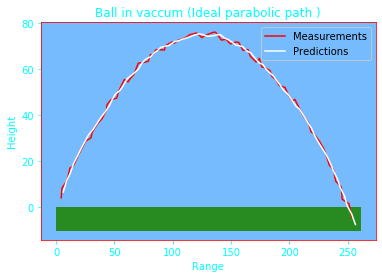

<Figure size 432x288 with 0 Axes>

In [132]:
x0 , y0 , v0 , theta = 0,0,50,50
state_noise_ball = [1,1]
dt = 0.1
r,q = 0.5,.1
#################################################


## Init filter and trajectory meas
kf = kf_ball_trajectory(dt = dt, r =  r, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q)
ball_pos = BallTrajectory2D(x0=x0, y0=y0, theta_deg=theta, velocity=v0, noise=state_noise_ball)

##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0

meas_list = []
preds_list = []

while ( y_meas >= 0):
    meas = ball_pos.step(dt)
    y_meas = meas[1]

    meas_list.append(meas)
    kf.updation(meas)


    preds = np.dot(kf.H,kf.prediction())
    preds_list.append(preds)

meas_list = np.array(meas_list)
preds_list = np.array(preds_list)
plt.title("Ball in vaccum (Ideal parabolic path )",color = 'cyan')
plt.xlabel("Range",color = 'cyan')
plt.ylabel("Height",color = 'cyan')
plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements",color = 'r')
plt.plot(preds_list[:,0],preds_list[:,1], label = "Predictions",color = 'w')
plt.rcParams['axes.facecolor']='xkcd:sky blue'

x = np.arange(0,np.amax(preds_list) + 5)
plt.fill_between(x,-10, 0.1,color = '#288B22')
plt.legend()
plt.figure()
plt.show()

### Trajectory in air (with air drag acting..)   ... basic code

Text(0, 0.5, 'Height')

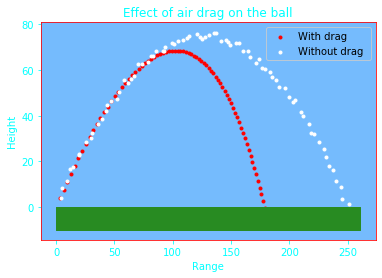

In [134]:
from math import sqrt, exp

def mph_to_mps(x):   ### miles per hour to mts per sec
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * (  0.0058 / 
            (1. + exp((velocity-35.)/5.)))### change 0.004

#v = mph_to_mps(110.)
def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*np.cos(launch_angle)
    v_y = vel*np.sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        


###inputs

dt = .1
x,y,v = 0,0,50
theta = np.radians(50)
### Plotting with drag and without air
x, y = solve(x=x, y=y, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='r', label='With drag',marker = '.')
plt.scatter(meas_list[:,0],meas_list[:,1],label = "Without drag ",color = 'w',marker = '.')
x = np.arange(0,np.amax(preds_list) + 5)
plt.fill_between(x,-10, 0.1,color = '#288B22')
plt.legend()
plt.title("Effect of air drag on the ball",color = 'cyan')
plt.xlabel("Range",color = 'cyan')
plt.ylabel("Height",color = 'cyan')

### Trajectory for accounting air drag .. used as meaurements.

In [99]:
class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = np.radians(launch_angle_deg)
        self.v_x = velocity_ms * np.cos(omega)
        self.v_y = velocity_ms * np.sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + np.exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt
        return np.array([[self.x + randn()*self.noise[0], self.y + randn()*self.noise[1]]]).T

### Linear KF failing to predict non-linearity

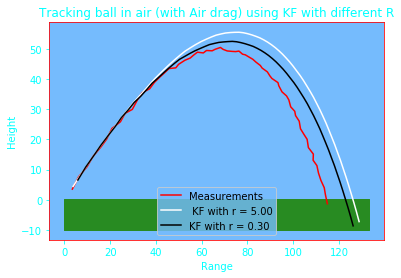

In [136]:

x0 , y0 , v0 , theta = 0,0,50,50
state_noise_ball = [.3,.3]
dt = .1
q1,q2 = 0,0
r1,r2 = 5,.3

f1 = kf_ball_trajectory(dt,   r1, theta, v0 ,x0 ,y0 ,q = q1)
f2 = kf_ball_trajectory(dt = dt, r =  r2, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q2)

ball_pos = BaseballPath(x0=x0, y0=y0, launch_angle_deg=theta, velocity_ms=v0, noise=state_noise_ball)
plt.figure()

##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0

t = 0

meas_list = []
preds_list_1 = []
preds_list_2 = []

while y_meas >= 0:
    
    meas = ball_pos.update(dt)
    y_meas = meas[1]
    meas_list.append(meas)

    f1.updation(meas)
    f2.updation(meas)
    
    preds_1 = np.dot(f1.H,f1.prediction())
    preds_list_1.append(preds_1)
    
    preds_2 = np.dot(f2.H,f2.prediction())
    preds_list_2.append(preds_2)

meas_list = np.array(meas_list)
preds_list_1 = np.array(preds_list_1)
preds_list_2 = np.array(preds_list_2)

plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements",color = 'r')
plt.plot(preds_list_1[:,0],preds_list_1[:,1], label = " KF with r = %.2f"%r1,color = 'white')
plt.plot(preds_list_2[:,0],preds_list_2[:,1], label = "KF with r = %.2f"%r2,color = 'black')


x = np.arange(0,np.amax(preds_list_1) + 5)
plt.fill_between(x,-10, 0.1,color = '#288B22')
plt.title("Tracking ball in air (with Air drag) using KF with different R",color='cyan')
plt.xlabel("Range",color='cyan')
plt.ylabel("Height",color='cyan')
plt.legend()

### Using Q to model the non-linearity

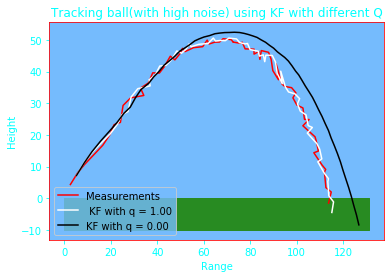

In [137]:

x0 , y0 , v0 , theta = 0,0,50,50
state_noise_ball = [1,1]   ### high noise to state the down side of Q
dt = .1
q1,q2 = 1,0
r1,r2 = .3,.3

f1 = kf_ball_trajectory(dt,   r1, theta, v0 ,x0 ,y0 ,q = q1)
f2 = kf_ball_trajectory(dt = dt, r =  r2, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q2)

ball_pos = BaseballPath(x0=x0, y0=y0, launch_angle_deg=theta, velocity_ms=v0, noise=state_noise_ball)
plt.figure()

##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0

t = 0

meas_list = []
preds_list_1 = []
preds_list_2 = []

while y_meas >= 0:
    
    meas = ball_pos.update(dt)
    y_meas = meas[1]
    meas_list.append(meas)

    f1.updation(meas)
    f2.updation(meas)
    
    preds_1 = np.dot(f1.H,f1.prediction())
    preds_list_1.append(preds_1)
    
    preds_2 = np.dot(f2.H,f2.prediction())
    preds_list_2.append(preds_2)

meas_list = np.array(meas_list)
preds_list_1 = np.array(preds_list_1)
preds_list_2 = np.array(preds_list_2)

plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements",color = 'r')
plt.plot(preds_list_1[:,0],preds_list_1[:,1], label = " KF with q = %.2f"%q1,color = 'white')
plt.plot(preds_list_2[:,0],preds_list_2[:,1], label = "KF with q = %.2f"%q2,color = 'black')


x = np.arange(0,np.amax(preds_list_2) + 5)
plt.fill_between(x,-10, 0.1,color = '#288B22')
plt.title("Tracking ball(with high noise) using KF with different Q",color = 'cyan')
plt.xlabel("Range",color = 'cyan')
plt.ylabel("Height",color = 'cyan')
plt.legend()